# Time series forecasting

In [ ]:
#!pip install prophet

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from datetime import date
import holidays

/home/xander/Documents/projects/MachineLearing-Forcasting/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# The data

This is a literal excerpt form the Kaggle data description found at https://www.kaggle.com/c/store-sales-time-series-forecasting

In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

### File Descriptions and Data Field Information

#### train.csv
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

#### test.csv
- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

#### sample_submission.csv
- A sample submission file in the correct format.

#### stores.csv
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

#### oil.csv
- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### holidays_events.csv
- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

#### Additional Notes
- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

## Loading the data

<Axes: xlabel='date', ylabel='sales'>

Error in callback <function _draw_all_if_interactive at 0x76a42bde1f80> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

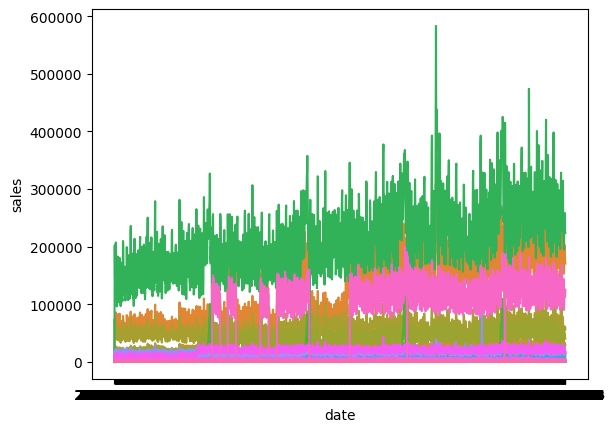

In [2]:
Store_df2 = pd.read_csv("store-sales-time-series-forecasting/train.csv")
all_shop_total2 = Store_df2.groupby(by=['date','family']).sum() 
sns.lineplot(all_shop_total2, x = 'date', y = 'sales', hue = 'family' , legend = False)


In [4]:
Store_df = pd.read_csv("store-sales-time-series-forecasting/train.csv")
Store_df['date']= pd.to_datetime(Store_df['date'])
Store_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
Store_df.shape

(3000888, 6)

In [5]:
all_shop_total = Store_df.groupby(by=['date','family']).sum() 
all_shop_total= all_shop_total.reset_index()  
all_shop_total.head()

,date,family,id,store_nbr,sales,onpromotion
0,2013-01-01,AUTOMOTIVE,47223,1485,0.0,0
1,2013-01-01,BABY CARE,47277,1485,0.0,0
2,2013-01-01,BEAUTY,47331,1485,2.0,0
3,2013-01-01,BEVERAGES,47385,1485,810.0,0
4,2013-01-01,BOOKS,47439,1485,0.0,0


<Axes: xlabel='date', ylabel='sales'>

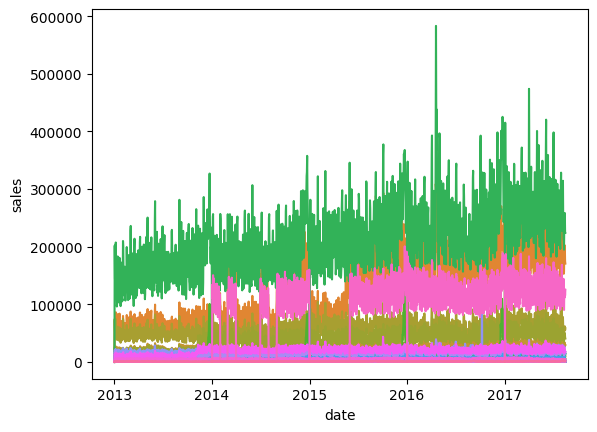

In [6]:
sns.lineplot(all_shop_total, x = 'date', y = 'sales', hue = 'family' , legend = False)


### Selecting a category of interest

Let's try to model the holdiay sales of 'LIQUOR,WINE,BEER' for the last christmas/new year period in the data

In [6]:
liq = all_shop_total[all_shop_total['family'] == 'LIQUOR,WINE,BEER']
liq.head()

,date,family,id,store_nbr,sales,onpromotion
22,2013-01-01,"LIQUOR,WINE,BEER",48411,1485,105.0,0
55,2013-01-02,"LIQUOR,WINE,BEER",144639,1485,2411.0,0
88,2013-01-03,"LIQUOR,WINE,BEER",240867,1485,2476.0,0
121,2013-01-04,"LIQUOR,WINE,BEER",337095,1485,4796.0,0
154,2013-01-05,"LIQUOR,WINE,BEER",433323,1485,6715.0,0


<Axes: xlabel='date', ylabel='sales'>

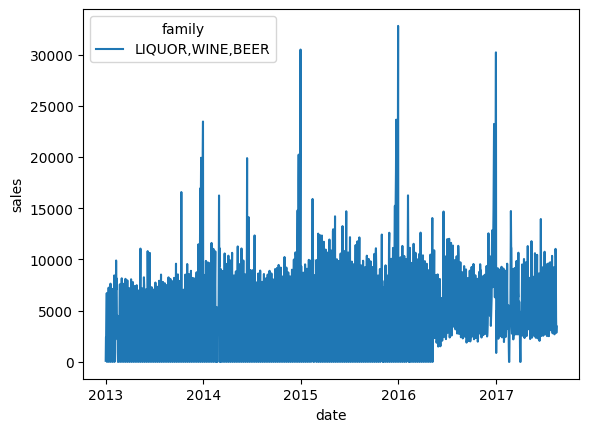

In [7]:
sns.lineplot(liq, x = 'date', y = 'sales', hue = 'family')


### changing dataframe to Prophet expected format

In [7]:

train_liq = liq[liq['date']<'2016-12-20']
test_liq = liq[liq['date']>='2016-12-20']

test_liq.head()

,date,family,id,store_nbr,sales,onpromotion
47740,2016-12-20,"LIQUOR,WINE,BEER",139194099,1485,9899.0,149
47773,2016-12-21,"LIQUOR,WINE,BEER",139290327,1485,12989.0,180
47806,2016-12-22,"LIQUOR,WINE,BEER",139386555,1485,14979.0,190
47839,2016-12-23,"LIQUOR,WINE,BEER",139482783,1485,19749.0,202
47872,2016-12-24,"LIQUOR,WINE,BEER",139579011,1485,23226.0,237


In [8]:

train_liq = train_liq[['date', 'sales']].rename(columns = {'date':'ds',
                                                          'sales':'y'})
train_liq

,ds,y
22,2013-01-01,105.0
55,2013-01-02,2411.0
88,2013-01-03,2476.0
121,2013-01-04,4796.0
154,2013-01-05,6715.0
...,...,...
47575,2016-12-15,6294.0
47608,2016-12-16,10952.0
47641,2016-12-17,12846.0
47674,2016-12-18,8039.0


In [9]:
test_liq = test_liq[['date', 'sales']].rename(columns = {'date':'ds',
                                                          'sales':'y'})
test_liq

,ds,y
47740,2016-12-20,9899.0
47773,2016-12-21,12989.0
47806,2016-12-22,14979.0
47839,2016-12-23,19749.0
47872,2016-12-24,23226.0
...,...,...
55429,2017-08-11,11033.0
55462,2017-08-12,10058.0
55495,2017-08-13,4294.0
55528,2017-08-14,2839.0


## Prophet forecasting

In [10]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(train_liq)

17:01:16 - cmdstanpy - INFO - Chain [1] start processing
17:01:16 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
forecast_days = 14
future = m.make_future_dataframe(periods=forecast_days )
future

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
1455,2016-12-29
1456,2016-12-30
1457,2016-12-31
1458,2017-01-01


In [14]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1455,2016-12-29,9211.114385,6694.169120,11832.321979
1456,2016-12-30,11658.998941,9052.867703,14514.552774
1457,2016-12-31,14232.696530,11634.657967,16821.060132
1458,2017-01-01,4678.337301,1867.091127,7205.382707
1459,2017-01-02,6465.187666,3722.999001,9205.461872


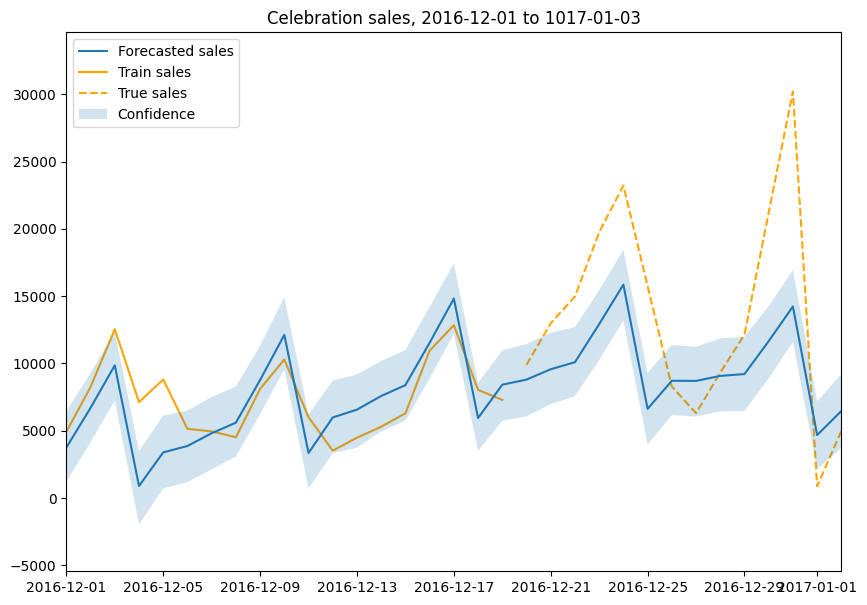

In [14]:
train_data_plot = train_liq
test_data_plot = test_liq

plt.figure(figsize = (10,7))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted sales', zorder = 1)
plt.plot(train_data_plot['ds'], train_data_plot['y'], label='Train sales', zorder = 0, color = 'orange')                                                                                       
plt.plot(test_data_plot['ds'], test_data_plot['y'], label='True sales', zorder = 0, color = 'orange', linestyle='dashed')
plt.fill_between(forecast['ds'], forecast['yhat_upper'], forecast['yhat_lower'],
                 alpha=.2, label='Confidence')
plt.title('Celebration sales, 2016-12-01 to 1017-01-03')
plt.legend()
plt.xlim(pd.to_datetime(['2016-12-01','2017-01-02']))
#plt.savefig('prophet_forecast.png')
plt.show()



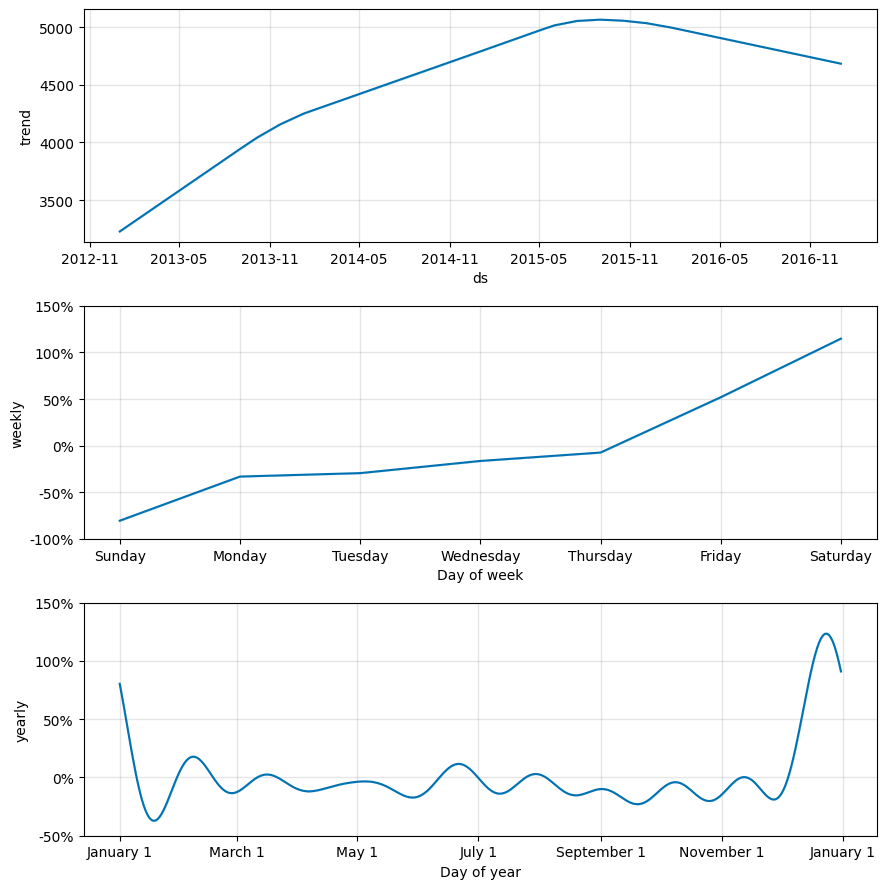

In [16]:
fig2 = m.plot_components(forecast)

## including holidays

In [17]:
holidays_national_local = pd.read_csv("store-sales-time-series-forecasting/holidays_events.csv")
holidays_national_local

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [18]:
holidays_national =holidays_national_local[holidays_national_local['locale'] == 'National' ].copy()
holidays_national['date'] = pd.to_datetime(holidays_national['date'])
holidays_national

,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [19]:
all_holidays = holidays_national[['description', 'date'] ].copy()
all_holidays.rename(columns={"description": "holiday", "date": "ds"}, inplace = True)
all_holidays['lower_window'] = 0
all_holidays['upper_window'] = 0
all_holidays

,holiday,ds,lower_window,upper_window
14,Primer Grito de Independencia,2012-08-10,0,0
19,Independencia de Guayaquil,2012-10-09,0,0
20,Traslado Independencia de Guayaquil,2012-10-12,0,0
21,Dia de Difuntos,2012-11-02,0,0
22,Independencia de Cuenca,2012-11-03,0,0
...,...,...,...,...
345,Navidad-3,2017-12-22,0,0
346,Navidad-2,2017-12-23,0,0
347,Navidad-1,2017-12-24,0,0
348,Navidad,2017-12-25,0,0


In [20]:
all_holidays.loc[all_holidays['holiday'].str.contains("Navidad"), 'holiday'] = "Navidad"

In [21]:
all_holidays

,holiday,ds,lower_window,upper_window
14,Primer Grito de Independencia,2012-08-10,0,0
19,Independencia de Guayaquil,2012-10-09,0,0
20,Traslado Independencia de Guayaquil,2012-10-12,0,0
21,Dia de Difuntos,2012-11-02,0,0
22,Independencia de Cuenca,2012-11-03,0,0
...,...,...,...,...
345,Navidad,2017-12-22,0,0
346,Navidad,2017-12-23,0,0
347,Navidad,2017-12-24,0,0
348,Navidad,2017-12-25,0,0


In [22]:
Drinks_Prophet_DF_train

NameError: name 'Drinks_Prophet_DF_train' is not defined

In [23]:
all_holidays[np.logical_and(all_holidays['ds'] >= Drinks_Prophet_DF_train['ds'].min() , all_holidays['ds'] < Drinks_Prophet_DF_train['ds'].max() ) ]


NameError: name 'Drinks_Prophet_DF_train' is not defined

## Training a model with holidays

In [24]:
m = Prophet(holidays=all_holidays,
            seasonality_mode='multiplicative')
m.add_regressor('temperature')
m.fit(train_liq)


forecast_days = 14
future = m.make_future_dataframe(periods=forecast_days )
future


forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.loc[forecast['yhat'] <0, 'yhat'] = 0

ValueError: Regressor 'temperature' missing from dataframe

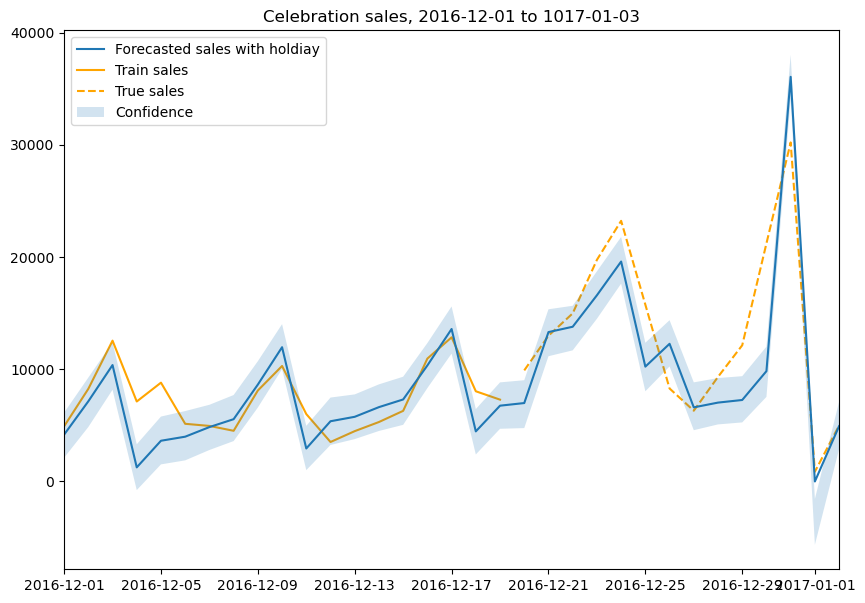

In [56]:
train_data_plot = train_liq
test_data_plot = test_liq

plt.figure(figsize = (10,7))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted sales with holdiay', zorder = 1)
plt.plot(train_data_plot['ds'], train_data_plot['y'], label='Train sales', zorder = 0, color = 'orange')                                                                                       
plt.plot(test_data_plot['ds'], test_data_plot['y'], label='True sales', zorder = 0, color = 'orange', linestyle='dashed')
plt.fill_between(forecast['ds'], forecast['yhat_upper'], forecast['yhat_lower'],
                 alpha=.2, label='Confidence')
plt.title('Celebration sales, 2016-12-01 to 1017-01-03')
plt.legend()
plt.xlim(pd.to_datetime(['2016-12-01','2017-01-02']))
#plt.savefig('prophet_forecast.png')
plt.show()

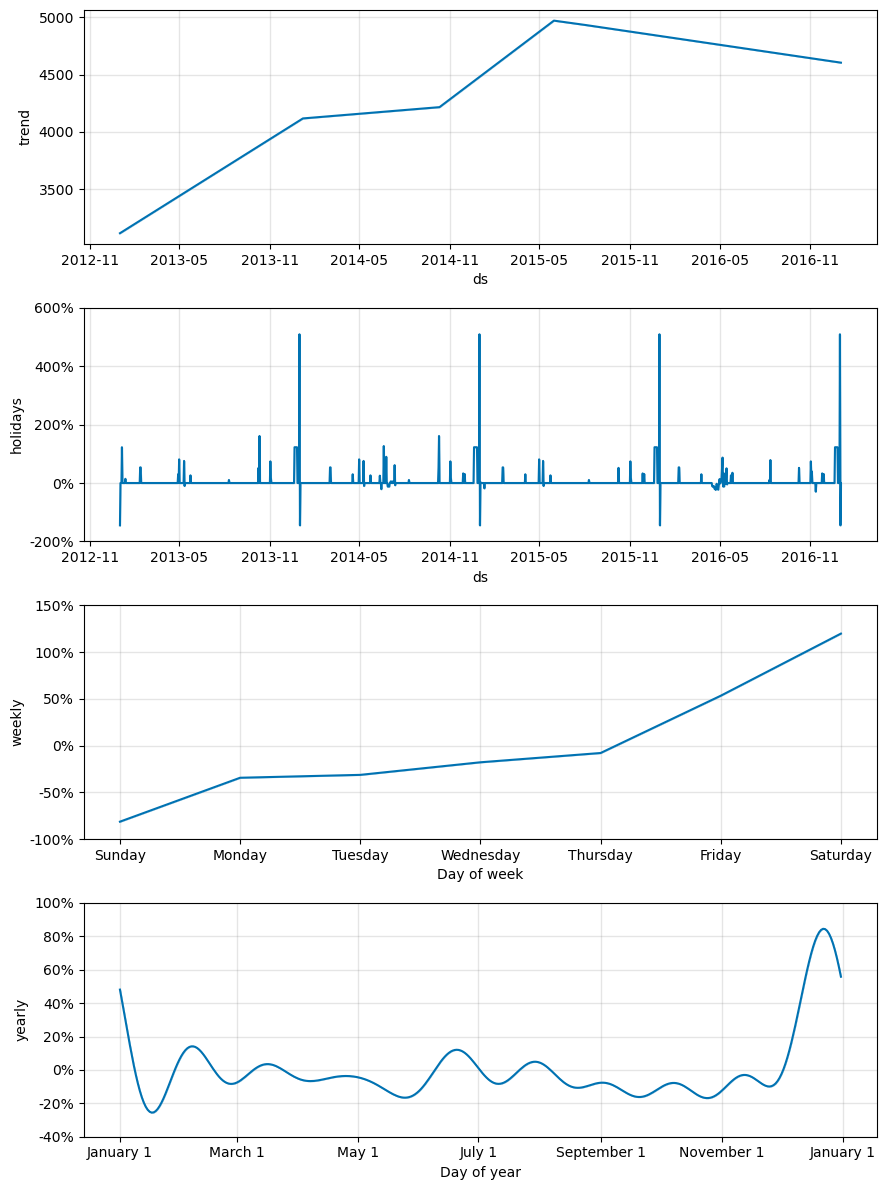

In [57]:
fig2 = m.plot_components(forecast)

In [25]:
RMSE_DF = test_liq.merge(forecast[['ds','yhat']], on = 'ds')
RMSE_DF

RMSE = np.sqrt((np.square(RMSE_DF['yhat']-RMSE_DF['y'])).mean())
RMSE

np.float64(6296.607247499688)

In [ ]:
forecast